## Netcdf: Interpolation between grids using cKDTree from Scipy library

In this post, we will see how to use pyMannKendall package functions on meteorological stations' time series.

We will use in this example daily temperature data from the second generation homogenized dataset of Environment and Climate Change Canada developed by Vincent et al. 2012. 

We will directly work with monthly indices of daily mean temperature. 

    
## 1-  Let's import Python librairies   

In [21]:
#data manipulation
import pandas as pd
import numpy as np
import datetime

#data statistics
import pymannkendall as mk
import statsmodels.api as sm

#for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pylab as plt
from carto import *
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")

##  2 - Loading source file

We will load work monthly mean of daily mean temperature for every stations over Canada.  


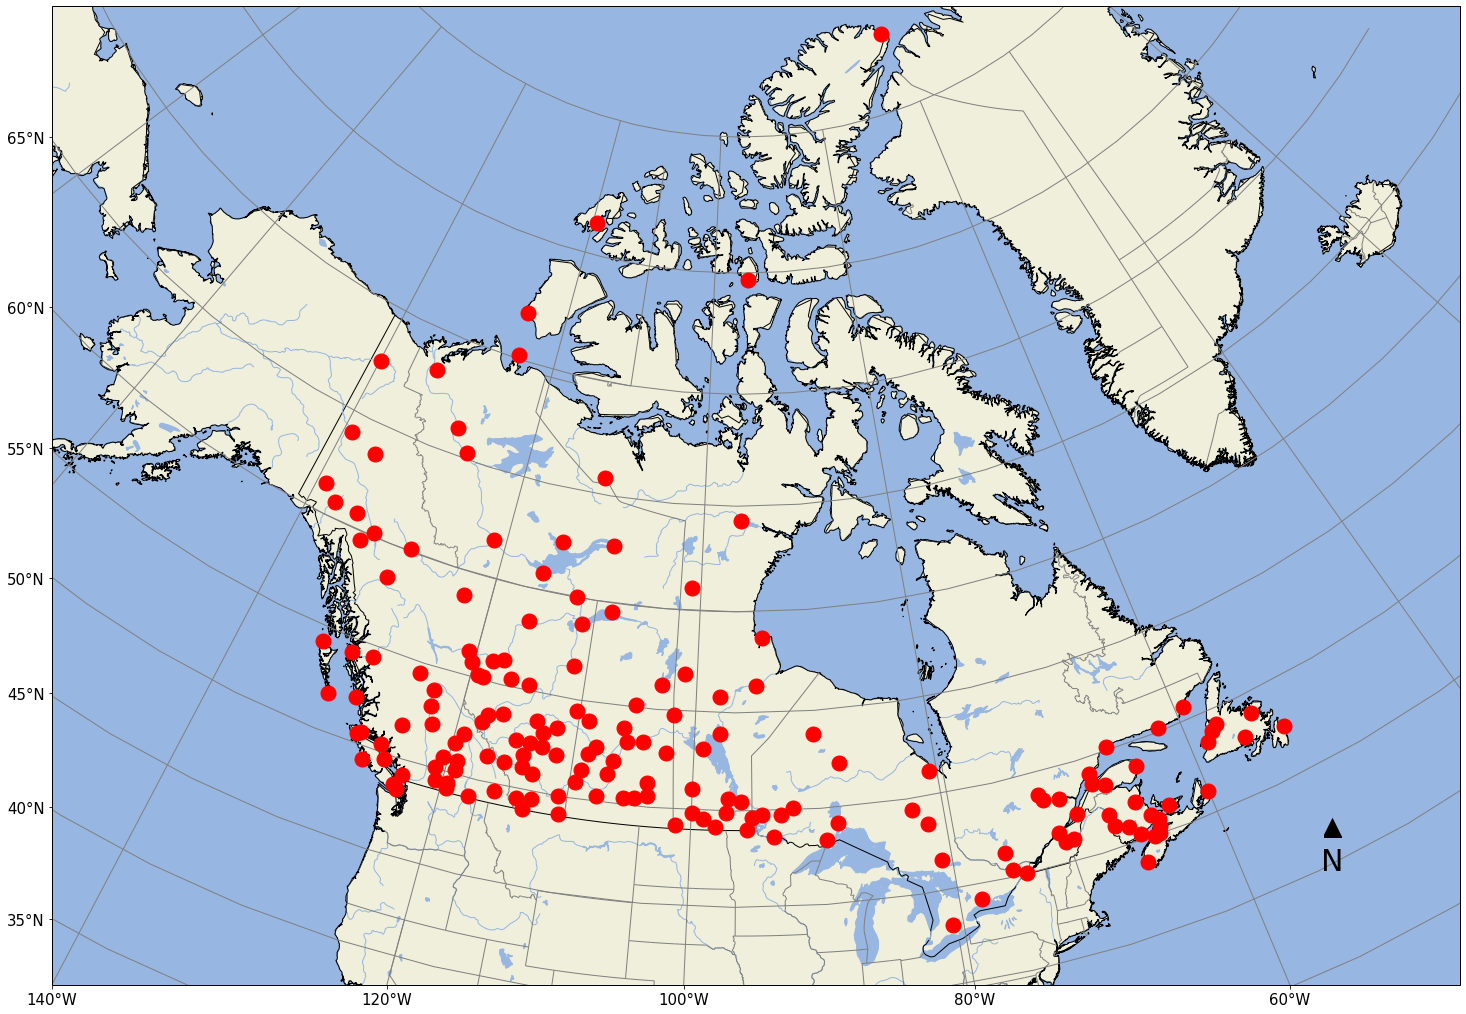

We will work with monthly values from 1970 to 2019. Let's work with all january months: 

In [7]:
yearmin = 1970                                                        #
yearmax = 2019   
dt=(yearmax-yearmin)+1                                                       #                                                                                                    
varin = 'Tasmoy'                 
indice = 'MOY' 
list_nom = pd.read_csv('F:/DATA/Donnees_Stations/2nd_generation_V2019/TEMP_ID/stations_noms_CANADA_'+str(yearmin)+'-'+str(yearmax)+'.csv',usecols = [1])
list_latlon = pd.read_csv('F:/DATA/Donnees_Stations/2nd_generation_V2019/TEMP_ID/stations_latlon_CANADA_'+str(yearmin)+'-'+str(yearmax)+'.csv',usecols = [1,2])
path_m = 'F:/DATA/Donnees_Stations/2nd_generation_V2019/INDICES/INDICES_MONTH/'+str(varin)+'/MOY/'+str(yearmin)+'_'+str(yearmax)+'/'

month = 1 
name_month = datetime.date(1900, int(month), 1).strftime('%B')

We will use the first sation in our list 'list_nom':  

In [9]:
station = list_nom['0'].iloc[1]
station

'BLIND_CHANNEL'

In [10]:
data = pd.read_csv(path_m + list_nom['0'].iloc[0] + '_MONTH_'+varin+'_'+indice+'_'+str(yearmin)+'_'+str(yearmax)+'_'+str('{:02d}'.format(month))+'.csv', skiprows=2)
data = data.rename(columns={ data.columns[1]: "var" }).set_index('datetime')
data.head()

,var
datetime,
1970-01-31,-15.632258
1971-01-31,-25.896774
1972-01-31,-24.874194
1973-01-31,-23.865385
1974-01-31,-26.232258


Quick plot with matplotlib: 

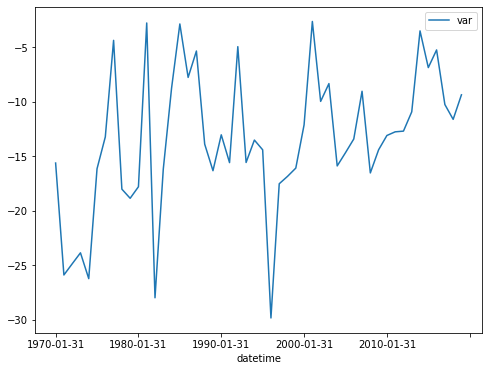

In [11]:
data.plot(figsize=(8,6));

We can assume the distribution of each variable fits a Gaussian (bell curve) distribution. If this is the case, we can use the Pearson’s correlation coefficient to summarize the correlation between the variables.

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

Below is an example of calculating and plotting the autocorrelation plot for the Monthly Mean of Mean Daily Temperatures using the plot_acf() function from the statsmodels library.

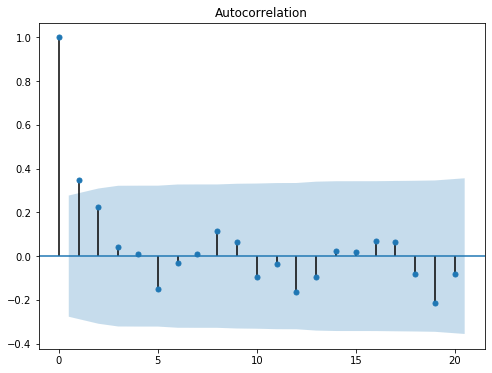

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
sm.graphics.tsa.plot_acf(data, lags=20, ax=ax);

We created a 2D plot showing the lag value along the x-axis and the correlation on the y-axis between -1 and 1.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

From this ACF plot, here show autocorrelation in the first lag. So, modified Mann Kendall test should be applied in here. We can use Hamed and Rao Modified MK Test, Yue and Wang Modified MK Test, Modified MK test using Pre-Whitening method or Modified MK test using Trend free Pre-Whitening method for this station Dataset.

In [13]:
mk.trend_free_pre_whitening_modification_test(data)

Modified_Mann_Kendall_Test_Trend_Free_PreWhitening_Approach(trend='increasing', h=True, p=0.0007050819678833253, z=3.3875953797502283, Tau=0.33503401360544216, s=394.0, var_s=13458.666666666666, slope=0.18567741935483859, intercept=-18.02651612903226)

From this result, we can say that there is a significant trend in this dataset. Because the p-value is smaller than alpha=0.05 and h=True. The trend is increasing and the value of trend/slope is 0.18567741935483859.

Modified MK test using Trend free Pre-Whitening show that there is a significant trend in this dataset. We can check this using other modified tests.

In [14]:
mk.hamed_rao_modification_test(data)

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.013359193023802174, z=2.4740475090816463, Tau=0.3142857142857143, s=385.0, var_s=24090.531318030477, slope=0.18567741935483859, intercept=-18.02651612903226)

In [15]:
mk.yue_wang_modification_test(data)

Modified_Mann_Kendall_Test_Yue_Wang_Approach(trend='increasing', h=True, p=1.6579404515937313e-11, z=6.733355507841542, Tau=0.3142857142857143, s=385.0, var_s=3252.3655991793858, slope=0.18567741935483859, intercept=-18.02651612903226)

In [16]:
mk.trend_free_pre_whitening_modification_test(data)

Modified_Mann_Kendall_Test_Trend_Free_PreWhitening_Approach(trend='increasing', h=True, p=0.0007050819678833253, z=3.3875953797502283, Tau=0.33503401360544216, s=394.0, var_s=13458.666666666666, slope=0.18567741935483859, intercept=-18.02651612903226)

All Modified test shows that there is a significant increasing trend. So we are sure about this trend.

Let's plot our previous timeserie with trend function: 

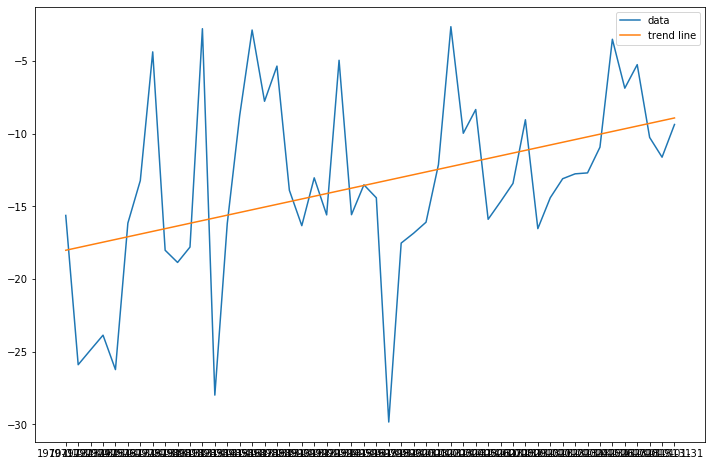

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
res = mk.trend_free_pre_whitening_modification_test(data)
trend_line = np.arange(len(data)) * res.slope + res.intercept

ax.plot(data)
ax.plot(data.index, trend_line)
ax.legend(['data', 'trend line'])

We can now make loops over  every stations, we will only keep significant (90%) stations' trend values so with p-value < 0.1. 
We are choosing to only use here modified Kendall-test <b>trend_free_pre_whitening_modification_test</b>. 

In [24]:
month=1
name_month = datetime.date(1900, int(month), 1).strftime('%B')
        
TREND=[]    
for  index, row in list_nom.iterrows():
    data = pd.read_csv(path_m + row[0] + '_MONTH_'+varin+'_'+indice+'_'+str(yearmin)+'_'+str(yearmax)+'_'+str('{:02d}'.format(month))+'.csv', skiprows=2)
    data = data.rename(columns={ data.columns[1]: "var" }).set_index('datetime') 
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.trend_free_pre_whitening_modification_test(data)
                
    if (p >= 0.1):   # aucune tendance n'a été détectée 
          slope=np.nan                             
    TREND.append(slope*10) 
            
trend = pd.DataFrame({'trend':TREND})
df= pd.concat([list_nom,trend,list_latlon], axis=1)               

And now we could plot all trends over Canada: 

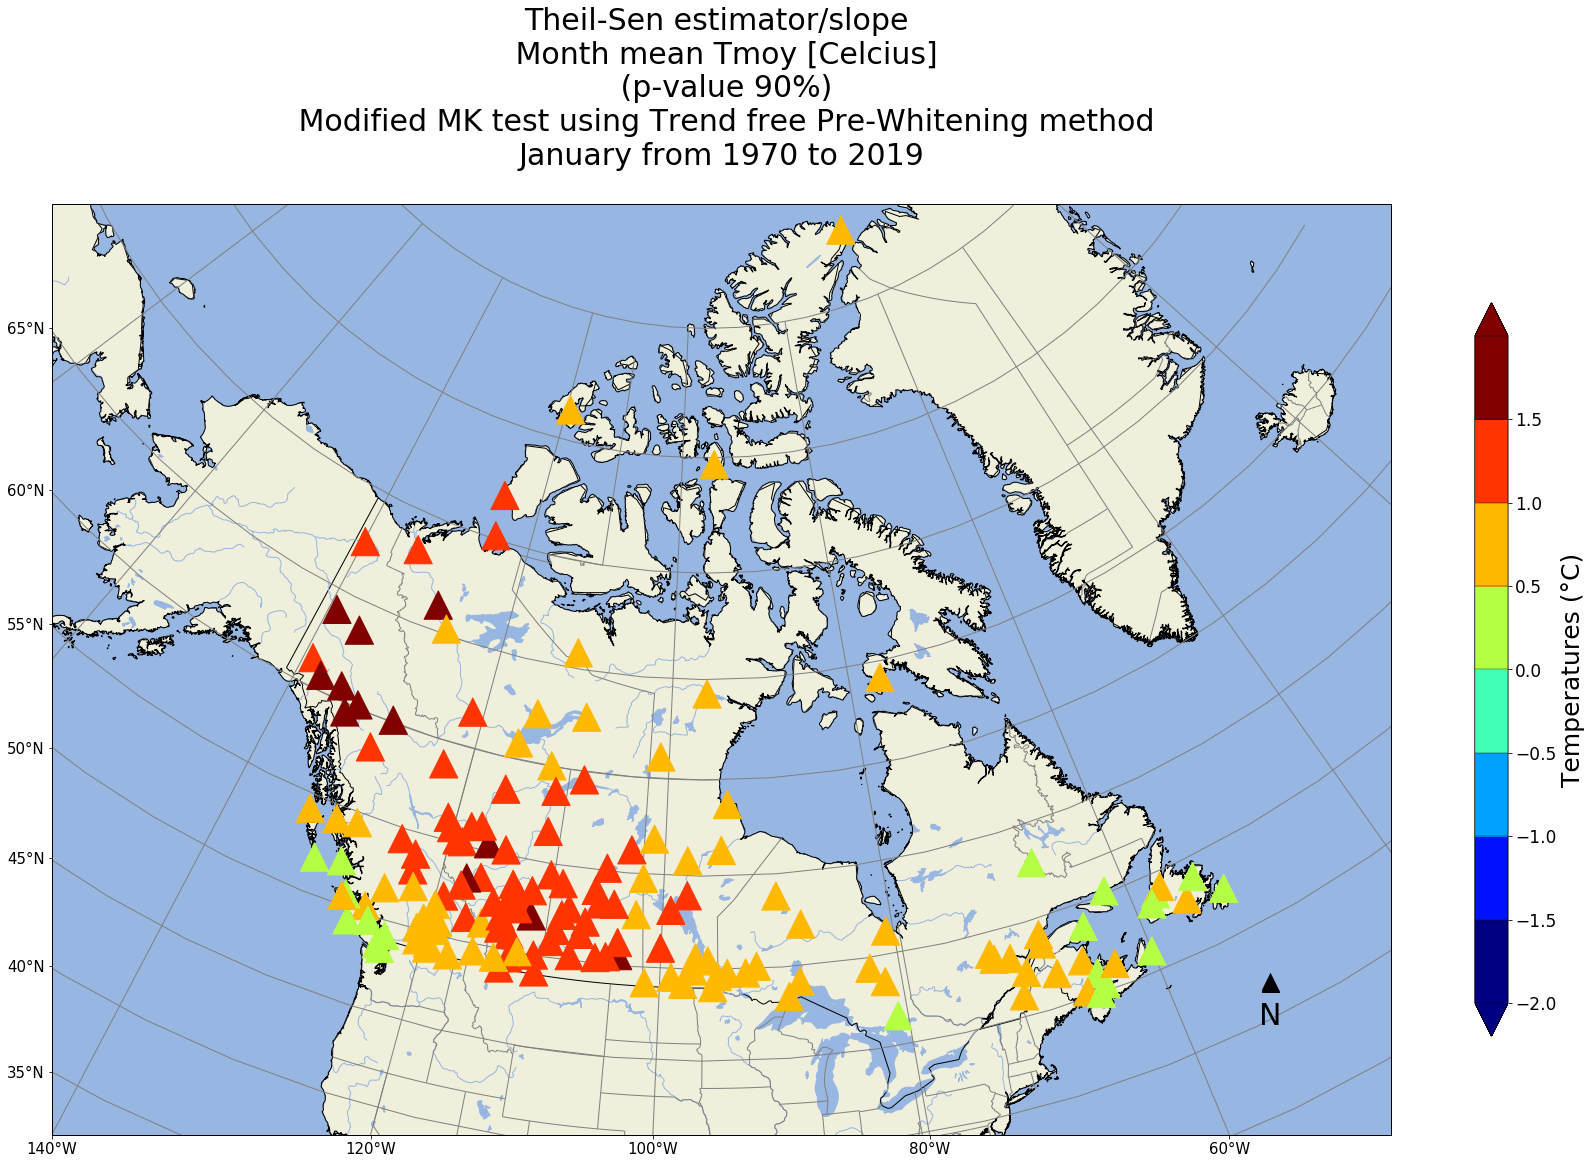

In [25]:
def plot_background(ax):
    ax.set_extent([-140,-50,32,82])  
    ax.coastlines(resolution='110m');
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), zorder=1)      
    ax.add_feature(cfeature.LAND.with_scale('50m'))       
    ax.add_feature(cfeature.LAKES.with_scale('50m'))     
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))    
    ax.add_feature(cfeature.RIVERS.with_scale('50m'))    
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',    
                        facecolor='none', name='coastline')
    ax.add_feature(coast, edgecolor='black')
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='gray') 
    return ax


fig=plt.figure(figsize=(30,18), frameon=True)    
        
crs=ccrs.LambertConformal()
ax = plt.axes(projection=crs)
        
plot_background(ax)
cmap = plt.cm.jet  # define the colormap
norm = mpl.colors.BoundaryNorm(np.arange(-2,2.1,0.5), cmap.N)
# Plots the data onto map
plt.scatter(df['Longitude'][(df['trend'] > 0)], 
             df['Latitude'][(df['trend'] > 0)],
             alpha=1.,
             s=800, label="Tmoy Trend",
             c=df['trend'][(df['trend'] > 0)],
             vmin=-2,
             vmax=2,
             cmap=cmap,
             norm=norm,
             transform=ccrs.PlateCarree(),
             marker="^", zorder=10)
        
mm =plt.scatter(df['Longitude'][(df['trend'] < 0)], 
                df['Latitude'][(df['trend'] < 0)],
                alpha=1.,
                s=800, label="Tmoy Trend",
                c=df['trend'][(df['trend'] < 0)],
                vmin=-2,
                vmax=2,
                cmap=cmap,
                norm=norm,
                transform=ccrs.PlateCarree(),
                marker="v", zorder=10)
fig.canvas.draw()
xticks = [-200, -180, -160, -140, -120, -100, -80, -60 ,-40, -20, 0]
yticks = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
ax.gridlines(xlocs=xticks, ylocs=yticks, linewidth=1, color='gray')
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)
    
      
ax.text(-55., 40.,  u'\u25B2\nN', color='black', fontsize=30, transform=ccrs.Geodetic())
        
string_title=u'Theil-Sen estimator/slope \n Month mean Tmoy [Celcius]\n (p-value 90%)\n Modified MK test using Trend free Pre-Whitening method\n' + name_month+' from ' + str(yearmin) +' to '+ str(yearmax)+'\n'
plt.title(string_title, size='xx-large', fontsize=30)
cbar = plt.colorbar(mm,  shrink=0.75, drawedges='True', ticks=np.arange(-2, 2.0, .5), extend='both',label='Temperatures (°C)')
cbar.ax.tick_params(labelsize=17) 
ax = cbar.ax
text = ax.yaxis.label
font = mpl.font_manager.FontProperties(size=25)
text.set_font_properties(font) 